<a href="https://colab.research.google.com/github/dath1s/NN-priority-2030/blob/main/CvT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Настройка среды

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from transformers import ConvNextForImageClassification, ConvNextFeatureExtractor
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch

# Датасет


## Импорт и преобразование датасета

In [ ]:
kaggle_path = '/content/drive/MyDrive/Dataset/dataset/'
train_dir = kaggle_path + 'Train'
val_dir = kaggle_path + 'Validation'
test_dir = kaggle_path + 'Test'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(160),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(160),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(160),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Создание DataLoader'а

In [ ]:
images_dataset = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

In [ ]:
dataloaders = {
    x: DataLoader(images_dataset[x], batch_size=16, shuffle=True, num_workers=1)
    for x in ['train', 'val', 'test']
}

## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np

In [ ]:
classes = ['Healthy', 'Powdery', 'Rust']

In [ ]:
train_distrib = {i: len(os.listdir(f'{train_dir}/{i}')) for i in classes}
test_distrib = {i: len(os.listdir(f'{test_dir}/{i}')) for i in classes}
val_distrib = {i: len(os.listdir(f'{val_dir}/{i}')) for i in classes}

In [ ]:
print("Train set:", sum(train_distrib.values()))
print("Test set:", sum(test_distrib.values()))
print("Validation set:", sum(val_distrib.values()))

Train set: 1322
Test set: 150
Validation set: 60


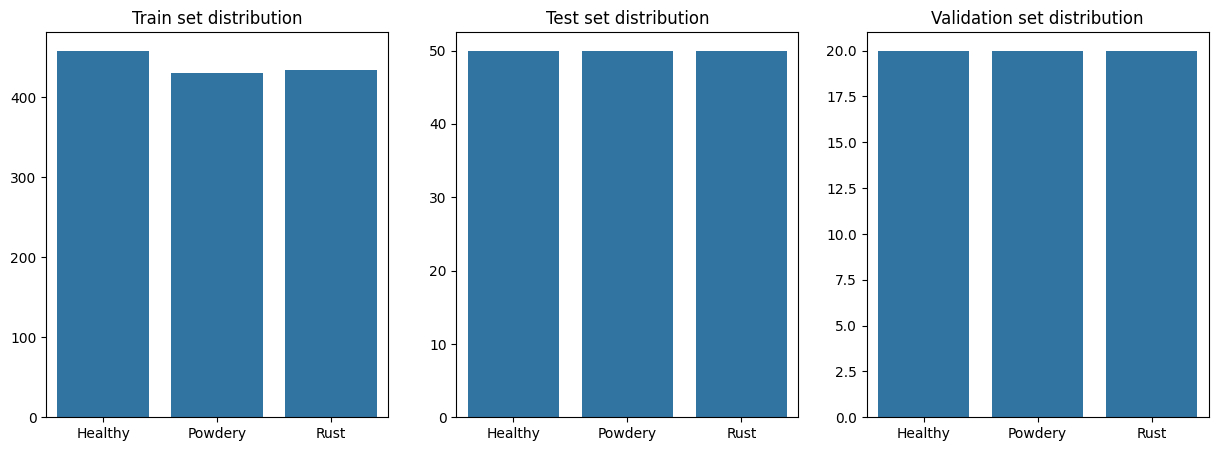

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=list(train_distrib.keys()), y=list(train_distrib.values()), ax=ax[0])
ax[0].set_title('Train set distribution')

sns.barplot(x=list(test_distrib.keys()), y=list(test_distrib.values()), ax=ax[1])
ax[1].set_title('Test set distribution')

sns.barplot(x=list(val_distrib.keys()), y=list(val_distrib.values()), ax=ax[2])
ax[2].set_title('Validation set distribution')

plt.show()

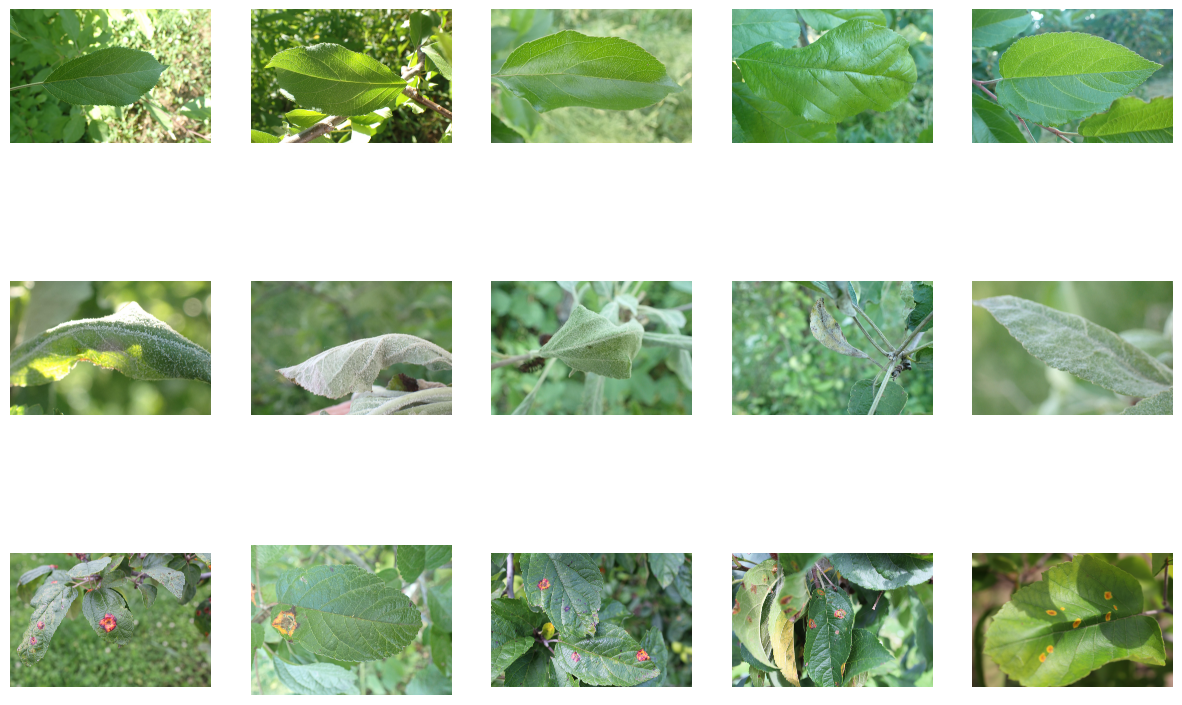

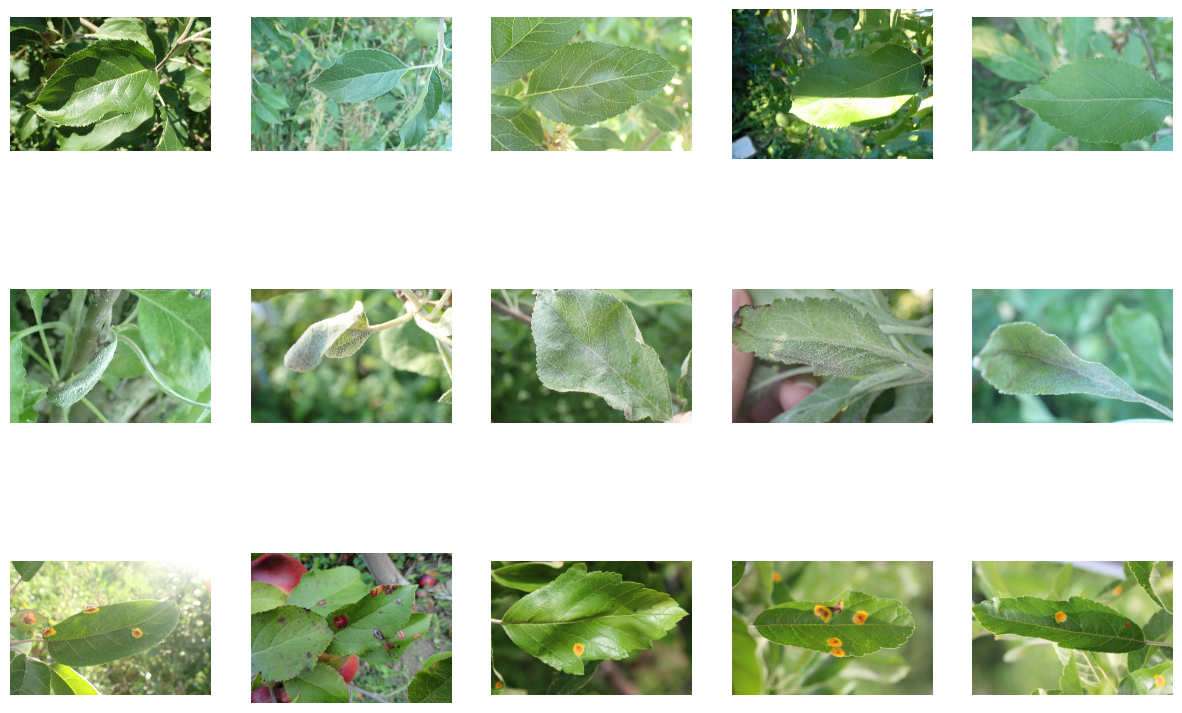

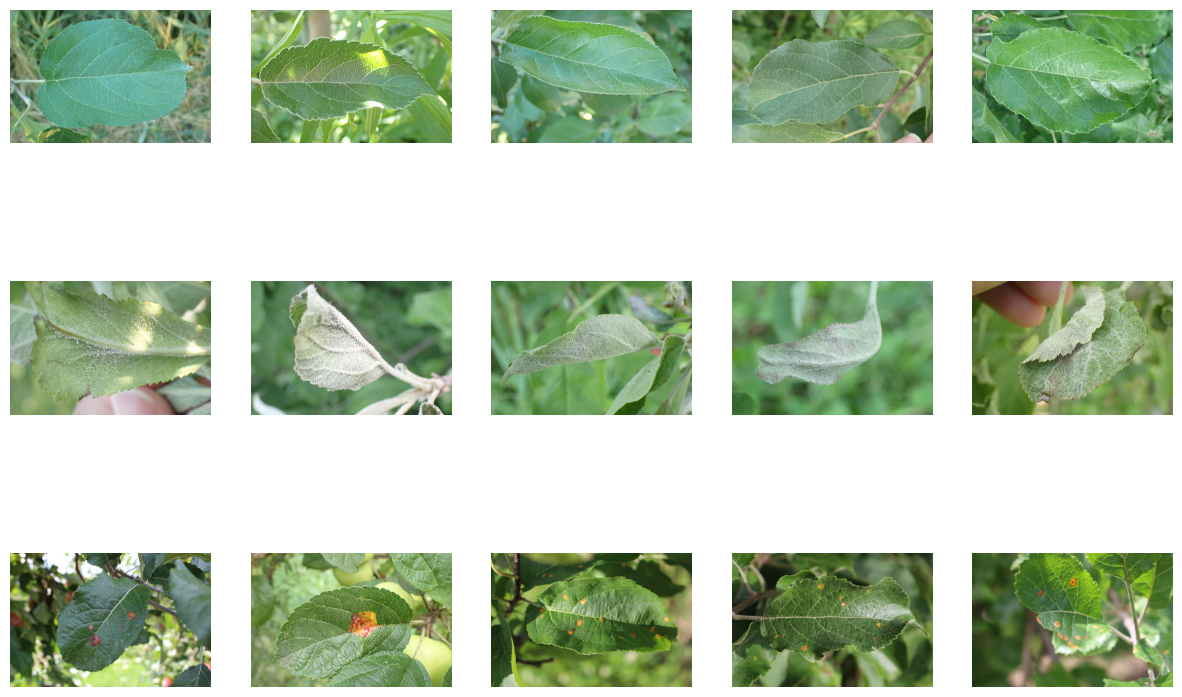

In [ ]:
def plot_random_images(path, n=5):
    fig, axes = plt.subplots(len(classes), n, figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)
        random_images = np.random.choice(images, n, replace=False)

        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(cls)

    plt.show()

plot_random_images(train_dir)
plot_random_images(test_dir)
plot_random_images(val_dir)

# Модель

In [ ]:
model_name = "microsoft/cvt-13"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

## Параметры модели

In [ ]:
num_classes = len(images_dataset['train'].classes)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Обучение модели

In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(model, dataloaders, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Эпоха {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Обнуляем градиенты

                with torch.set_grad_enabled(phase == 'train'):  # Включаем градиенты только при обучении
                    outputs = model(inputs).logits
                    loss = criterion(outputs, labels)

                    if phase == 'train':  # Обратное распространение ошибки только при обучении
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        torch.cuda.empty_cache()
        print()

    return model

model_trained = train_model(model, dataloaders, num_epochs=10)

Эпоха 1/10


100%|██████████| 83/83 [18:19<00:00, 13.25s/it]


Train - Loss: 0.9365, Accuracy: 0.5325


100%|██████████| 4/4 [00:33<00:00,  8.26s/it]


Val - Loss: 0.6755, Accuracy: 0.7000

Эпоха 2/10


100%|██████████| 83/83 [18:01<00:00, 13.03s/it]


Train - Loss: 0.7197, Accuracy: 0.6717


100%|██████████| 4/4 [00:23<00:00,  5.90s/it]


Val - Loss: 0.5474, Accuracy: 0.8333

Эпоха 3/10


100%|██████████| 83/83 [18:06<00:00, 13.09s/it]


Train - Loss: 0.6029, Accuracy: 0.7262


100%|██████████| 4/4 [00:22<00:00,  5.51s/it]


Val - Loss: 0.5215, Accuracy: 0.8333

Эпоха 4/10


100%|██████████| 83/83 [18:15<00:00, 13.20s/it]


Train - Loss: 0.5175, Accuracy: 0.7738


100%|██████████| 4/4 [00:23<00:00,  5.92s/it]


Val - Loss: 0.4949, Accuracy: 0.8167

Эпоха 5/10


100%|██████████| 83/83 [18:08<00:00, 13.12s/it]


Train - Loss: 0.5569, Accuracy: 0.7474


100%|██████████| 4/4 [00:23<00:00,  5.78s/it]


Val - Loss: 0.4368, Accuracy: 0.8333

Эпоха 6/10


100%|██████████| 83/83 [18:12<00:00, 13.16s/it]


Train - Loss: 0.4690, Accuracy: 0.7890


100%|██████████| 4/4 [00:22<00:00,  5.52s/it]


Val - Loss: 0.2825, Accuracy: 0.8833

Эпоха 7/10


100%|██████████| 83/83 [18:09<00:00, 13.12s/it]


Train - Loss: 0.4843, Accuracy: 0.7625


100%|██████████| 4/4 [00:32<00:00,  8.19s/it]


Val - Loss: 0.2734, Accuracy: 0.9333

Эпоха 8/10


100%|██████████| 83/83 [18:27<00:00, 13.34s/it]


Train - Loss: 0.4620, Accuracy: 0.7806


100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


Val - Loss: 0.1415, Accuracy: 0.9667

Эпоха 9/10


100%|██████████| 83/83 [18:05<00:00, 13.07s/it]


Train - Loss: 0.4217, Accuracy: 0.7995


100%|██████████| 4/4 [00:28<00:00,  7.17s/it]


Val - Loss: 0.1967, Accuracy: 0.9167

Эпоха 10/10


100%|██████████| 83/83 [18:07<00:00, 13.10s/it]


Train - Loss: 0.4186, Accuracy: 0.7995


100%|██████████| 4/4 [00:23<00:00,  5.90s/it]

Val - Loss: 0.1345, Accuracy: 0.9500



## Сохранение и загрузка модели

In [ ]:
torch.save(model_trained.state_dict(), 'model_weights.pth')

In [ ]:
# Загрузка
model = AutoModelForImageClassification.from_pretrained("microsoft/cvt-13")

num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Тестирование модели

In [ ]:
from sklearn.metrics import f1_score

def test_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Test Accuracy: {100 * correct / total}%')
    print(f'F1-score: {f1:.4f}')

test_model(model, dataloaders['test'])

100%|██████████| 10/10 [00:54<00:00,  5.45s/it]

Test Accuracy: 91.33333333333333%
F1-score: 0.9129


# Результаты свертки

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

model = AutoModelForImageClassification.from_pretrained("microsoft/cvt-13")

num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
         transforms.Resize(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

input_image = preprocess_image('/content/drive/MyDrive/Dataset/dataset/Test/Rust/82add70df6ab2854.jpg')

activation = {}

def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            activation[name] = output[0].detach()
        else:
            activation[name] = output.detach()
    return hook

model.cvt.encoder.stages[0].embedding.convolution_embeddings.projection.register_forward_hook(get_activation('conv_activations'))

with torch.no_grad():
    output = model(input_image)

activations = activation['conv_activations']

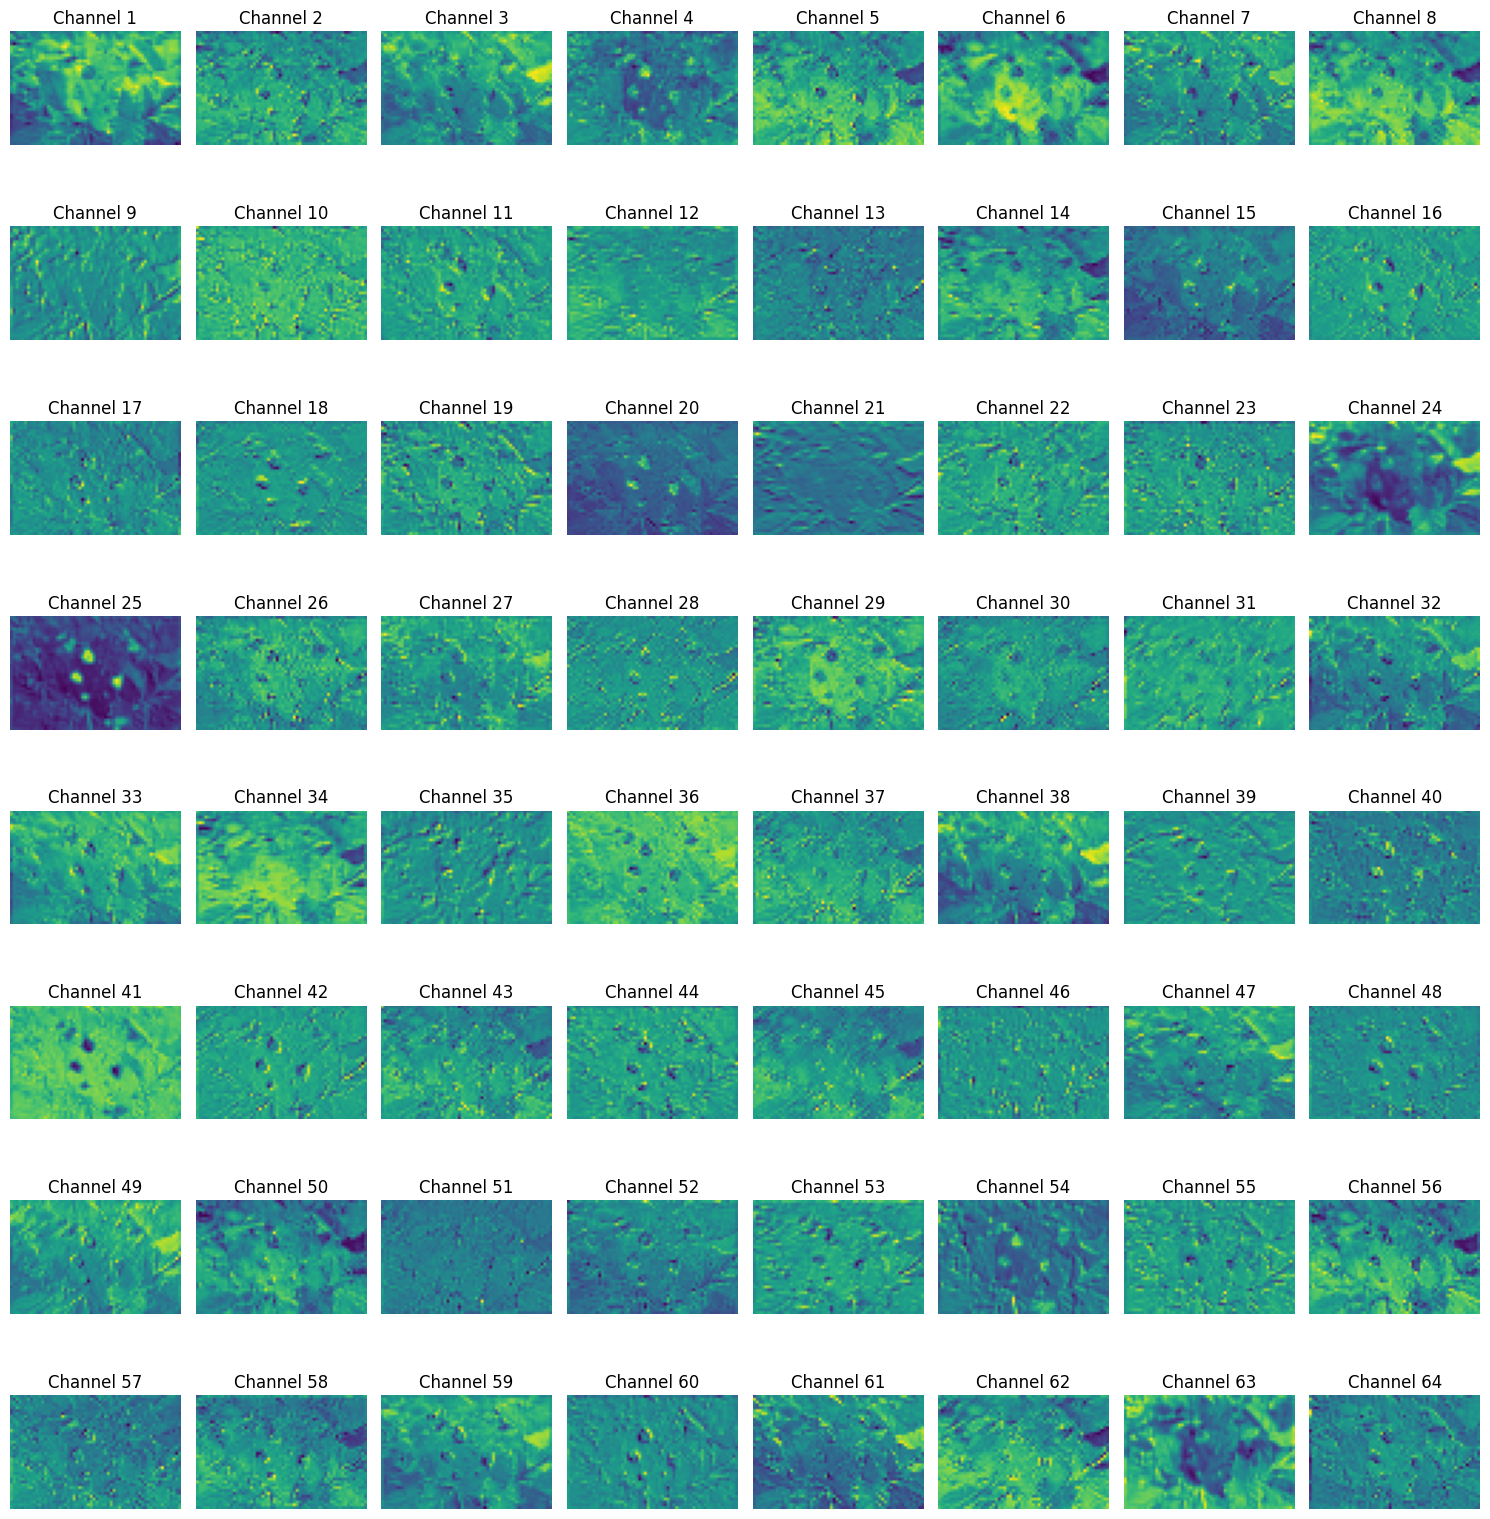

In [ ]:
batch_size, channels, height, width = activations.shape

cols = 8
rows = (channels + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))
axes = axes.flatten()

for i in range(channels):
    ax = axes[i]
    ax.imshow(activations[0, i].cpu().numpy(), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Channel {i + 1}')

for i in range(channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()